Why semi-supervised learning?

https://stats.stackexchange.com/questions/321841/what-are-variational-autoencoders-and-to-what-learning-tasks-are-they-used

Ideal parameters:
$$ \min_{\boldsymbol{\lambda}}\mathcal{D}[p(\mathbf{z}\vert \mathbf{x})\vert\vert q(\mathbf{z}\vert \mathbf{x},\boldsymbol{\lambda})] $$

It should also minimize the reconstruction loss (and optional regularization terms, mainly L1 or L2)

VAE loss function:
$$ELBO(\boldsymbol{\lambda})= E_{q(\boldsymbol{z}\vert \mathbf{x},\boldsymbol{\lambda})}[\log p(\mathbf{x}\vert\boldsymbol{z})]-\mathcal{D}[(q(\boldsymbol{z}\vert \mathbf{x},\boldsymbol{\lambda})\vert\vert p(\boldsymbol{z})]$$

$$ q(\mathbf{z}\vert \mathbf{x},\boldsymbol{\lambda}) = \mathcal{N}(\mathbf{z}\vert\boldsymbol{\mu}(\mathbf{x}), \boldsymbol{\sigma}^2(\mathbf{x})I) $$

conditional distribution:
$$ p_{\boldsymbol{\phi}}(\mathbf{x}\vert\mathbf{z}) = \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}(\mathbf{z}; \boldsymbol{\phi}), \boldsymbol{\sigma}(\mathbf{z}; \boldsymbol{\phi})^2I)$$


$$ ELBO(\boldsymbol{\theta},\boldsymbol{\phi})= \sum_i E_{q_{\boldsymbol{\theta}}(\boldsymbol{z}\vert \mathbf{x}_i,\boldsymbol{\lambda})}[\log p_{\boldsymbol{\phi}}(\mathbf{x}_i\vert\boldsymbol{z})]-\mathcal{D}[(q_{\boldsymbol{\theta}}(\boldsymbol{z}\vert \mathbf{x}_i,\boldsymbol{\lambda})\vert\vert p(\boldsymbol{z})] $$

In [2]:
from models.generative.autoencoders.vae.vae import VariationalAutoencoder
from models.generative.autoencoders.vae.ladder_vae import LadderVariationalAutoencoder
from models.generative.autoencoders.vae.sylvester_vae import SylvesterVAE
from utils.utils import dict_of_int_highest_elements, plot_evaluation



/home/simon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


O-sylvester


In [3]:
# files_destinations
home_path = "/home/simon/"
destination_folder = "annleukemia"
data_folder = "data"
results_folder = "results"
meta_destination_folder = "pandas_meta_df"

plots_folder_path = "/".join([home_path, destination_folder, results_folder, "plots/"])


In [4]:
#dataset_name = "gse33000_and_GSE24335_GSE44768_GSE44771_GSE44770"
dataset_name = "gse33000+4"
geo_ids = ["GSE33000"]
# Contrary to ssl, I don't also put the labelled ID in the unlabelled, as it is just redundent here
unlabelled_geo_ids = ["GSE33000", "GSE24335", "GSE44768" , "GSE44771", "GSE44770"] 
activation = "relu"
#nrep = 3
betas=(0.9, 0.999)
vae_flavour = "o-sylvester"
early_stopping = 200
labels_per_class = 0
n_epochs = 100
warmup = 0
gt_input = 0

# if ladder is yes builds a ladder vae. Do not combine with auxiliary (yet; might be possible and relatively 
# not too hard to implement, but might be overkill. Might be interesting too)
translate = "n" 


In [5]:
# Ladder VAE (L-VAE)
ladder = False
# Load pre-computed vae (unsupervised learning)
load_vae = False



Definition of the hyper-parameters

In [7]:
lr = 1e-4
l1 = 0.
l2 = 0.
batch_size = 128
mc = 1 # seems to be a problem when mc > 1 for display only, results seem good
iw = 1 # seems to be a problem when iw > 1 for display only, results seem good

# Neurons layers
h_dims = [128, 64]
z_dims = [50]

# number of flows
n_combinations = 20 #could be just 1 with number_of_flows?
number_of_flows = 8
num_elements = 3

is_example = False


In [8]:
bad_geo_ids = [""] # Now useless, didn't work well, but stil complains without it. to be removed.

In [9]:
# Files destinations
load_from_disk = True
load_merge = False
home_path = "/home/simon/"
destination_folder = "annleukemia"
data_folder = "data"
results_folder = "results"
meta_destination_folder = "pandas_meta_df"
plots_folder_path = "/".join([home_path, destination_folder, 
                              results_folder, "plots/"])

In [10]:
from utils.utils import adapt_datasets
g = GeoParser(home_path=home_path, geo_ids=geo_ids, unlabelled_geo_ids=unlabelled_geo_ids, bad_geo_ids=None)
g.get_geo(load_from_disk=load_from_disk, automatic_attribute_list=None)
meta_df = g.merge_datasets(load_from_disk=load_merge, labelled=True)
unlabelled_meta_df = g.merge_datasets(load_from_disk=load_merge, labelled=False)
if translate is "y":
    for geo_id in geo_ids:
        g.translate_indices_df(geo_id, labelled=True)
    for geo_id in unlabelled_geo_ids:
        g.translate_indices_df(geo_id, labelled=False)

#meta_df, unlabelled_meta_df = adapt_datasets(meta_df, unlabelled_meta_df)


Running: GSE33000
Loading GSE33000, labelled: True ...
File found at location: /home/simon//annleukemia/data//GSE33000_labelledTrue_dataframe.pickle.npy
self.df[geo_id] (35371, 624)

Running unlabelled: GSE24335
Loading GSE24335, labelled: False ...
File found at location: /home/simon//annleukemia/data//GSE24335_labelledFalse_dataframe.pickle.npy
self.unlabelled_df[geo_id] (35371, 2200)

Running unlabelled: GSE44768
Loading GSE44768, labelled: False ...
File found at location: /home/simon//annleukemia/data//GSE44768_labelledFalse_dataframe.pickle.npy
self.unlabelled_df[geo_id] (35371, 230)

Running unlabelled: GSE44771
Loading GSE44771, labelled: False ...
File found at location: /home/simon//annleukemia/data//GSE44771_labelledFalse_dataframe.pickle.npy
self.unlabelled_df[geo_id] (35371, 230)

Running unlabelled: GSE44770
Loading GSE44770, labelled: False ...
File found at location: /home/simon//annleukemia/data//GSE44770_labelledFalse_dataframe.pickle.npy
self.unlabelled_df[geo_id] (

In [11]:
if ladder:
    vae = LadderVariationalAutoencoder(vae_flavour, z_dims=z_dims, h_dims=h_dims, n_flows=number_of_flows,
                                       num_elements=num_elements)
    z_dim = z_dims[-1]
elif vae_flavour in ["o-sylvester", "h-sylvester", "t-sylvester"]:
    print("vae_flavour", vae_flavour)
    vae = SylvesterVAE(vae_flavour, z_dims=z_dims, h_dims=h_dims, n_flows=number_of_flows,
                       num_elements=num_elements, auxiliary=False)
else:
    print("vae_flavour", vae_flavour)
    vae = VariationalAutoencoder(vae_flavour, z_dim=z_dims, h_dims=h_dims, n_flows=number_of_flows,
                                 auxiliary=False, a_dim=0)


vae_flavour o-sylvester
a_dim (making sure it stays ok for ssl_vae) 0
self.a_dim 0


/home/simon/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [12]:
vae.set_configs(home_path=home_path, results_folder=results_folder, data_folder=data_folder,
               destination_folder=destination_folder, dataset_name=dataset_name, lr=lr,
               meta_destination_folder="meta_pandas_dataframes", csv_filename="csv_loggers", is_unlabelled=True)

In [13]:
print("Labeled data shape (35371, 624)", meta_df.shape)
print("unlabelled meta_df shape", unlabelled_meta_df.shape)

if meta_df is not None:
    vae.import_dataframe(meta_df, batch_size, labelled=True)
    vae.import_dataframe(unlabelled_meta_df, batch_size, labelled=False)

Labeled data shape (35371, 624) (35371, 624)
unlabelled meta_df shape (35371, 2890)


PCA saved at:  /home/simon//annleukemia/results/plots/


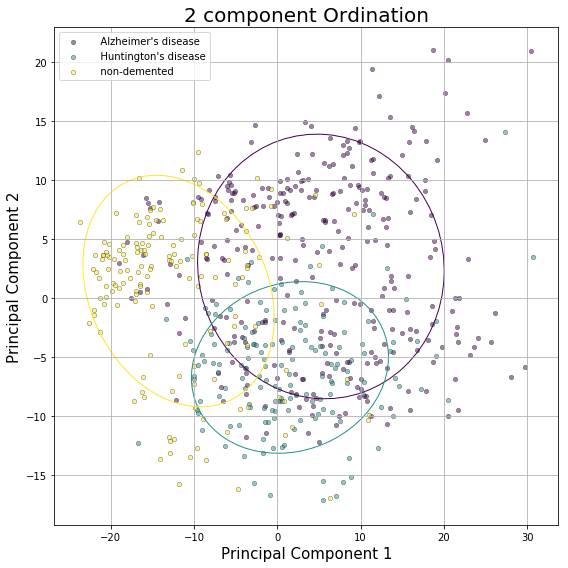

In [14]:
print("PCA saved at: ", plots_folder_path)
ordination2d(meta_df, epoch="pre", dataset_name=dataset_name, ord_type="pca",
             images_folder_path=plots_folder_path)



In [15]:
vae.define_configurations(vae_flavour, early_stopping=100, warmup=warmup, ladder=ladder, z_dim=z_dims[-1], auxiliary=False, ssl=False)
vae.set_data(is_example=False, labels_per_class=labels_per_class)
if ladder:
    print("Setting ladder layers")
    vae.set_lvae_layers()
else:
    vae.set_vae_layers()

if load_vae:
    vae.load_model()


create model
2890 unlabelled train samples
499 train samples
62 valid samples
63 test samples
624 total samples
self.train_loader 4
self.train_loader 128
self.train_loader <torch.utils.data.sampler.RandomSampler object at 0x7f129aea7c88>


In [16]:
vae.run(epochs=n_epochs, clip_grad=1e-4)

beta: 1.0
Labelled 4


/home/simon/anaconda3/lib/python3.6/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Unlabelled: 23
EVALUATION!
BEST EVALUATION LOSS: SAVING MODEL
MODEL SAVED AT LOCATION: /home/simon//annleukemia/results/models/history/
Epoch: 0/100, Time elapsed: 6.31478810s
* Train loss: 3691.84683990   (re: 3639.06487274, kl: 52.78199732)
o Val.  loss: 547.04022217   (re: 540.06292725, kl: 6.97731304)
--> Early stopping: 0/100 (BEST: 100000.00000000)

beta: 1.0
Labelled 4
Unlabelled: 23
EVALUATION!
Epoch: 1/100, Time elapsed: 1.49710846s
* Train loss: 3677.05345917   (re: 3622.67530823, kl: 54.37820029)
o Val.  loss: 549.02056885   (re: 541.42114258, kl: 7.59949160)
--> Early stopping: 1/100 (BEST: 100000.00000000)

MODEL SAVED AT LOCATION: /home/simon//annleukemia/results/models/history/
beta: 1.0
Labelled 4
Unlabelled: 23
EVALUATION!
BEST EVALUATION LOSS: SAVING MODEL
MODEL SAVED AT LOCATION: /home/simon//annleukemia/results/models/history/
Epoch: 2/100, Time elapsed: 1.51505661s
* Train loss: 3631.79994202   (re: 3578.10433960, kl: 53.69570124)
o Val.  loss: 545.43420410   (re: 

KeyboardInterrupt: 

References
Auto-Encoding Variational Bayes https://arxiv.org/abs/1312.6114
Semi-Supervised Learning with Deep Generative Models https://arxiv.org/abs/1406.5298
Ladder Variational Autoencoders https://arxiv.org/abs/1602.02282
Auxiliary Deep Generative Models    https://arxiv.org/abs/1602.05473
Sylvester Normalizing Flows for Variational Inference  https://arxiv.org/abs/1803.05649
Improving Variational Auto-Encoders using Householder Flow https://arxiv.org/abs/1611.09630
Variational Inference with Normalizing Flows https://arxiv.org/abs/1505.05770
Convex combination linear IAF and the Householder Flow, J.M. Tomczak & M. Welling https://jmtomczak.github.io/deebmed.html

Github Ressources:
    https://github.com/wohlert/semi-supervised-pytorch
    https://github.com/jmtomczak/vae_vpflows
    https://github.com/jmtomczak/vae_householder_flow